# DM - Classification [TASK 3]

Library imports and initial settings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from wittgenstein import RIPPER
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

# import tensor flow for NN
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

from utils import fetch_preprocessed_dataset, store_preprocessed_dataset, build_grid_plot

import sys
import logging as lg
import warnings

# setup logging
warnings.filterwarnings("ignore")

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

Fetching users_num dataset saved in classification phase.

In [2]:
# Load the users_num dataset from csv
dataset = fetch_preprocessed_dataset(step_name="users_total")
users_num = dataset['users_num.csv']

`users_num` is a dataset composed by numerical attributes of `users`.

In [3]:
users_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  11508 non-null  int64  
 1   statuses_count              11508 non-null  int64  
 2   bot                         11508 non-null  int64  
 3   tweets_num                  11508 non-null  int64  
 4   tweets_2020_num             11508 non-null  int64  
 5   likes_num                   11508 non-null  float64
 6   comments_num                11508 non-null  float64
 7   ratio_likes_x_tweets        11508 non-null  float64
 8   entropy                     11508 non-null  float64
 9   texts_mean_length           11508 non-null  float64
 10  texts_special_chars_length  11508 non-null  float64
 11  mean_pub_range              11508 non-null  float64
 12  mean_texts_similarity       11508 non-null  float64
dtypes: float64(8), int64(5)
memory 

## Dataset preparation

Splitting dataset in training and test set. Each of the two part is a couple of input values and labels.

In [4]:
dataset = users_num.copy()
label = dataset.pop('bot')

# use 20% of dataset for testing
train_set, test_set, train_label, test_label = train_test_split(dataset, label, stratify=label, test_size=0.20)

print("train_set:", train_set.shape)
print("train_label:", train_label.shape)
print("test_set:", test_set.shape)
print("test_label:", test_label.shape)

train_set: (9206, 12)
train_label: (9206,)
test_set: (2302, 12)
test_label: (2302,)


## Classification models

Dictionary used to collect models predictions in order to compare them in the end of the analysis.

In [5]:
predictions = {}

### Scaling data

Scale data using MinMaxScaler object from sklearn library. 

In [6]:
scaler = MinMaxScaler()
# invoke the scaling (fit method)
scaler.fit(train_set, test_set)

train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

In [7]:
#
# Define a gridsearch function that takes as input the train set, the train label, 
# the model and a grid of hyperparameters.
# It returns the results of search, where we can extract the best one using .best_params_ attribute.
#
def gridsearch(train_set, train_label, model, param_grid):
    gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=4)
    return gs.fit(train_set, train_label)

In [1]:
#
# Utility function for printing the metrics for classification.
#
def report_scores(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    print("TRAIN")
    print(metrics.classification_report(tr_label,
                            train_pred,
                            target_names=['user', 'bot']))
    print("TEST")
    print(metrics.classification_report(ts_label,
                            test_pred,
                            target_names=['user', 'bot']))

NameError: name 'train_label' is not defined

In [9]:
#
# Utility function for plotting the confusion matrix.
#
def plot_cms(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    def plot_cm(title, label, pred):
        cm = metrics.confusion_matrix(label, pred)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['user', 'bot'])
        disp.plot()
        disp.ax_.set_title(title)

    plot_cm("TRAIN", tr_label, train_pred)
    plot_cm("TEST", ts_label, test_pred)

## Models

Now we start playing with all the models that we have selected for this task.

### Decision tree

In [10]:
# define the hyperparameters.
params = dict(
    max_depth=[5, 10, 20, 30, 40, 50],
    min_samples_leaf=[1, 2, 3, 4, 5]
)

# Build the model
dt = DecisionTreeClassifier(criterion='gini', splitter='best')
# Execute gridsearch
scores = gridsearch(train_set, train_label, dt, params)

scores

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 3, 4, 5]})

In [11]:
# Show best params for Decision Tree
scores.best_params_

{'max_depth': 10, 'min_samples_leaf': 1}

In [12]:
# Create the tuned model specifying as criterion the gini index.
dt = DecisionTreeClassifier(criterion='gini', splitter='best', **scores.best_params_)
dt.fit(train_set, train_label)

DecisionTreeClassifier(max_depth=10)

In [13]:
# Collect data
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

predictions["Decision tree"] = (train_pred_dt, test_pred_dt)

#### Decision Tree Report

In [14]:
report_scores(train_pred_dt, test_pred_dt)

TRAIN
              precision    recall  f1-score   support

        user       0.97      0.74      0.84      4313
         bot       0.81      0.98      0.89      4893

    accuracy                           0.87      9206
   macro avg       0.89      0.86      0.86      9206
weighted avg       0.89      0.87      0.86      9206

TEST
              precision    recall  f1-score   support

        user       0.92      0.71      0.80      1079
         bot       0.79      0.95      0.86      1223

    accuracy                           0.83      2302
   macro avg       0.85      0.83      0.83      2302
weighted avg       0.85      0.83      0.83      2302



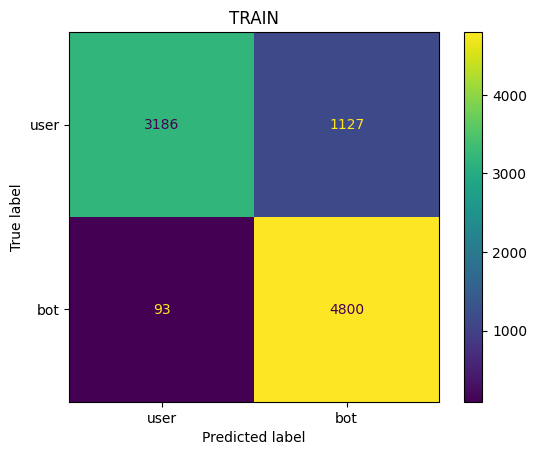

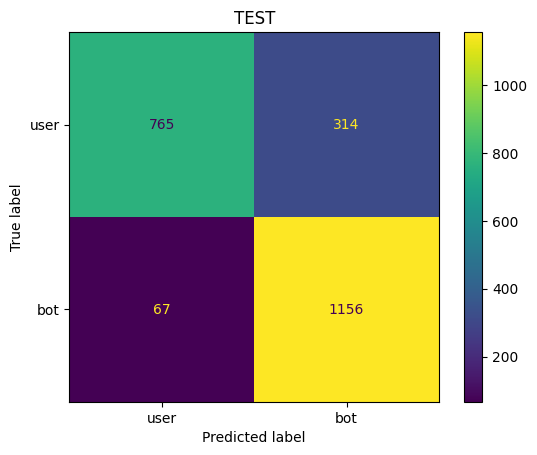

In [15]:
plot_cms(train_pred_dt, test_pred_dt)

### K-nearest neighbors

In [16]:
# create the hyperparams dictionary
params = dict(n_neighbors=list(range(1, int(math.sqrt(train_set.shape[0])))))

# create the KNN moel
knn = KNeighborsClassifier()

# execute the gridsearch
scores = gridsearch(train_set_scaled, train_label, knn, params)

scores

GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]})

In [2]:
# show the best hyperparamaters for K-NN
scores.best_params_

NameError: name 'scores' is not defined

In [18]:
# create the model with the best params
knn = KNeighborsClassifier(**scores.best_params_)
# Fit the model
knn = knn.fit(train_set_scaled, train_label)

In [19]:
# Collect data
train_pred_knn = knn.predict(train_set_scaled)
test_pred_knn = knn.predict(test_set_scaled)

predictions["KNN"] = (train_pred_knn, test_pred_knn)

#### K-NN Reports

In [20]:
report_scores(train_pred_knn, test_pred_knn)

TRAIN
              precision    recall  f1-score   support

        user       0.89      0.57      0.69      4313
         bot       0.71      0.94      0.81      4893

    accuracy                           0.77      9206
   macro avg       0.80      0.75      0.75      9206
weighted avg       0.80      0.77      0.76      9206

TEST
              precision    recall  f1-score   support

        user       0.87      0.57      0.69      1079
         bot       0.71      0.93      0.80      1223

    accuracy                           0.76      2302
   macro avg       0.79      0.75      0.75      2302
weighted avg       0.79      0.76      0.75      2302



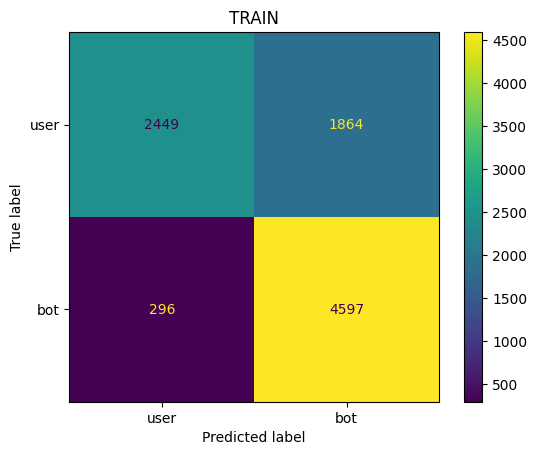

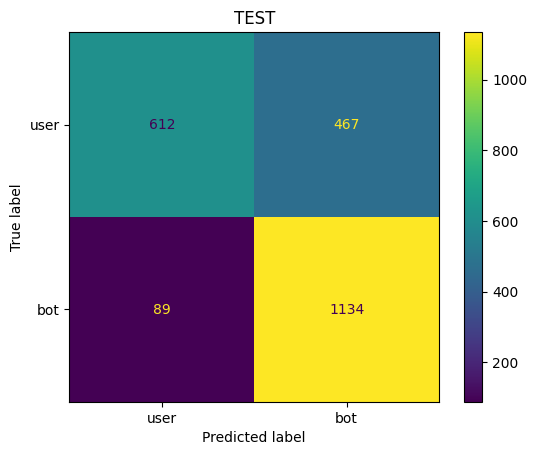

In [21]:
plot_cms(train_pred_knn, test_pred_knn)

### Rule-based

In [22]:
# RIPPER doesn't work with entropy rounded more than 4
train_set_rb = train_set.copy()
train_set_rb['entropy'] = train_set_rb['entropy'].map(lambda x: round(x, 4))

In [23]:
# define the hyperparameters
params = dict(
    k=[1, 2, 3],
    prune_size=[0.2, 0.33, 0.5]
)

# create the model
rb = RIPPER(random_state=0)
# execute gridsearch
scores = gridsearch(train_set_rb, train_label, rb, params)

scores

/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed 

GridSearchCV(cv=4,
             estimator=<RIPPER(n_discretize_bins=10, k=2, dl_allowance=64, max_rules=None, random_state=0, max_rule_conds=None, prune_size=0.33, verbosity=0, max_total_conds=None)>,
             n_jobs=-1,
             param_grid={'k': [1, 2, 3], 'prune_size': [0.2, 0.33, 0.5]})

In [24]:
# Show best params for the RIPPER model
scores.best_params_

{'k': 1, 'prune_size': 0.5}

In [25]:
# Create the model with the tuned hyperparameters
rb = RIPPER(random_state=0, **scores.best_params_)
# train
rb.fit(train_set_rb, y=train_label)

List of rules discovered with ripper algorithm.

In [26]:
rb.out_model()

[[entropy=<0.0001 ^ statuses_count=<20.0 ^ texts_mean_length=52.83-59.48 ^ tweets_num=19.0-34.0] V
[entropy=<0.0001 ^ statuses_count=20.0-34.0] V
[entropy=0.0001-0.0002 ^ statuses_count=45.0-58.0 ^ likes_num=1.0-4.0 ^ texts_mean_length=63.0-65.43] V
[entropy=<0.0001 ^ statuses_count=<20.0 ^ mean_pub_range=225066.35-406691.07] V
[entropy=0.0001-0.0002 ^ statuses_count=45.0-58.0] V
[entropy=<0.0001 ^ statuses_count=<20.0 ^ mean_pub_range=<2795.85 ^ texts_special_chars_length=<3.4] V
[statuses_count=34.0-45.0 ^ ratio_likes_x_tweets=<0.015 ^ texts_mean_length=52.83-59.48] V
[texts_special_chars_length=5.48-5.86 ^ mean_texts_similarity=0.021-0.024 ^ texts_mean_length=82.12-89.44] V
[entropy=<0.0001 ^ statuses_count=34.0-45.0] V
[entropy=0.0001-0.0002 ^ statuses_count=34.0-45.0] V
[entropy=0.0001-0.0002 ^ mean_pub_range=81997.68-97671.41] V
[entropy=<0.0001 ^ statuses_count=<20.0 ^ mean_pub_range=>834193.93 ^ Unnamed:0=6900.0-8047.5] V
[entropy=<0.0001 ^ statuses_count=<20.0] V
[mean_texts_s

In [27]:
# Collect Data
train_pred_rb = rb.predict(train_set)
test_pred_rb = rb.predict(test_set)

predictions["Rule-based"] = (train_pred_rb, test_pred_rb)

#### RIPPER Model Report

In [28]:
report_scores(train_pred_rb, test_pred_rb)

TRAIN
              precision    recall  f1-score   support

        user       0.79      0.68      0.73      4313
         bot       0.75      0.84      0.79      4893

    accuracy                           0.77      9206
   macro avg       0.77      0.76      0.76      9206
weighted avg       0.77      0.77      0.76      9206

TEST
              precision    recall  f1-score   support

        user       0.87      0.68      0.76      1079
         bot       0.76      0.91      0.83      1223

    accuracy                           0.80      2302
   macro avg       0.81      0.79      0.80      2302
weighted avg       0.81      0.80      0.80      2302



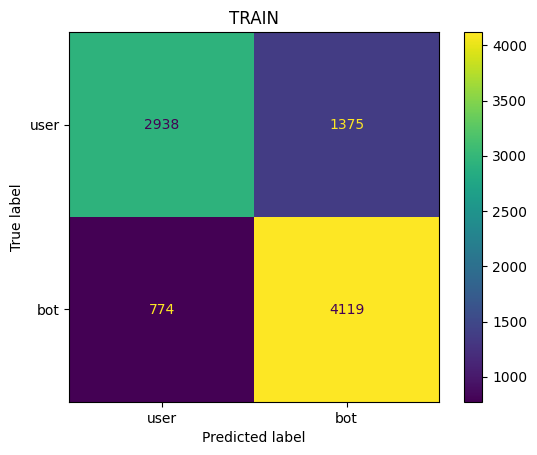

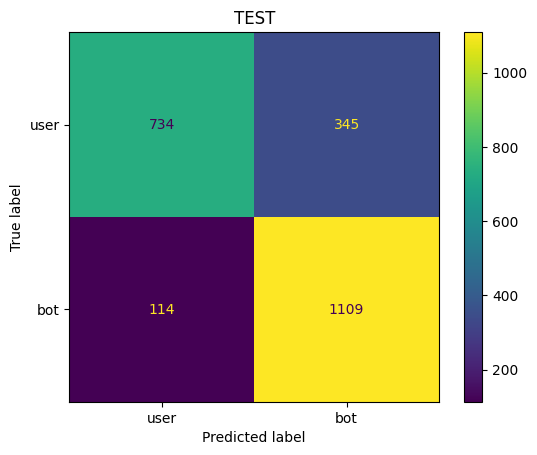

In [29]:
plot_cms(train_pred_rb, test_pred_rb)

### Naive Bayes

For this model there are not relevant hyperparameters, so we do not perform gridsearch.

In [3]:
# Create the Model and train it.

nb = GaussianNB()
nb.fit(train_set, train_label)

NameError: name 'GaussianNB' is not defined

In [31]:
# Collect data
train_pred_nb = nb.predict(train_set)
test_pred_nb = nb.predict(test_set)

predictions["Naive Bayes"] = (train_pred_nb, test_pred_nb)

#### Naive Bayes Report

In [32]:
report_scores(train_pred_nb, test_pred_rb)

TRAIN
              precision    recall  f1-score   support

        user       0.71      0.28      0.40      4313
         bot       0.59      0.90      0.71      4893

    accuracy                           0.61      9206
   macro avg       0.65      0.59      0.55      9206
weighted avg       0.64      0.61      0.56      9206

TEST
              precision    recall  f1-score   support

        user       0.87      0.68      0.76      1079
         bot       0.76      0.91      0.83      1223

    accuracy                           0.80      2302
   macro avg       0.81      0.79      0.80      2302
weighted avg       0.81      0.80      0.80      2302



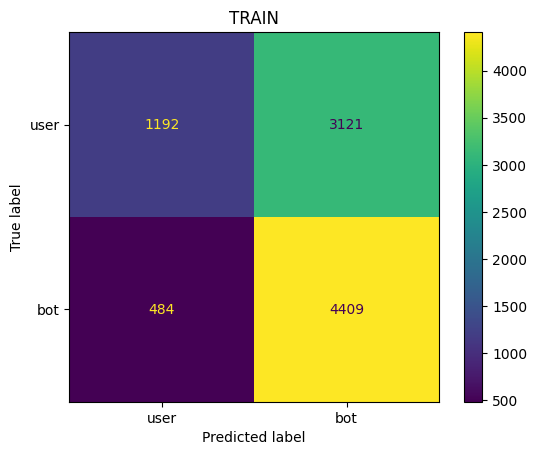

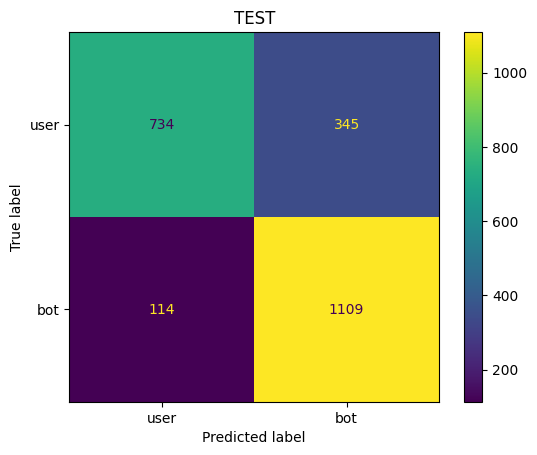

In [33]:
plot_cms(train_pred_nb, test_pred_rb)

### Ensemble methods

#### AdaBoost

In [34]:
# Define hyperparameters
params = dict(
    n_estimators=list(range(10, 201, 10)),
    learning_rate=[0.1, 0.3, 0.05, 0.01]
)

# create the classificator
boost = AdaBoostClassifier()
# execute gridsearch
scores = gridsearch(train_set, train_label, boost, params)

scores

GridSearchCV(cv=4, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.05, 0.01],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200]})

In [4]:
# Show best params
scores.best_params_

NameError: name 'scores' is not defined

In [36]:
# Create the model with tuned paramaters
boost = AdaBoostClassifier(**scores.best_params_)
# Train it!
boost.fit(train_set, train_label)

AdaBoostClassifier(learning_rate=0.3, n_estimators=200)

In [37]:
# Collect data
train_pred_boost = boost.predict(train_set)
test_pred_boost = boost.predict(test_set)

predictions["AdaBoost"] = (train_pred_boost, test_pred_boost)

#### AdaBoost report

In [38]:
report_scores(train_pred_boost, test_pred_boost)

TRAIN
              precision    recall  f1-score   support

        user       0.92      0.69      0.79      4313
         bot       0.78      0.95      0.85      4893

    accuracy                           0.83      9206
   macro avg       0.85      0.82      0.82      9206
weighted avg       0.85      0.83      0.82      9206

TEST
              precision    recall  f1-score   support

        user       0.91      0.70      0.79      1079
         bot       0.78      0.94      0.85      1223

    accuracy                           0.83      2302
   macro avg       0.84      0.82      0.82      2302
weighted avg       0.84      0.83      0.82      2302



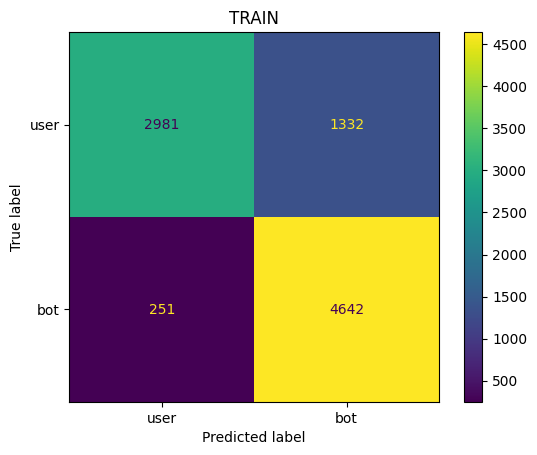

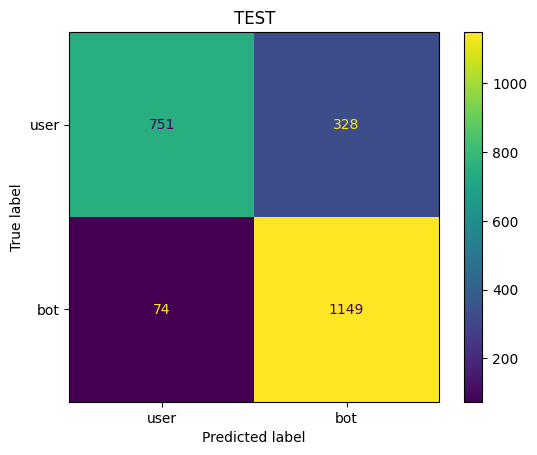

In [39]:
plot_cms(train_pred_boost, test_pred_boost)

#### Random forest

In [40]:
# Define the hyperparameters
params = dict(
    n_estimators=list(range(10, 201, 10)) # use 10,20,30,...,200 estimators
)

# create the model
rf = RandomForestClassifier()
# Execute the gridsearch
scores = gridsearch(train_set, train_label, rf, params)

scores

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200]})

In [41]:
# Show best params
scores.best_params_

{'n_estimators': 80}

In [42]:
# Create the model with tuned hyperparameters
rf = RandomForestClassifier(**scores.best_params_)
# Fit it
rf.fit(train_set, train_label)

RandomForestClassifier(n_estimators=80)

In [43]:
# Collect data
train_pred_rf = rf.predict(train_set)
test_pred_rf = rf.predict(test_set)

predictions["Random forest"] = (train_pred_rf, test_pred_rf)

#### Random Forest Report

In [44]:
report_scores(train_pred_rf, test_pred_rf)

TRAIN
              precision    recall  f1-score   support

        user       1.00      1.00      1.00      4313
         bot       1.00      1.00      1.00      4893

    accuracy                           1.00      9206
   macro avg       1.00      1.00      1.00      9206
weighted avg       1.00      1.00      1.00      9206

TEST
              precision    recall  f1-score   support

        user       0.89      0.72      0.80      1079
         bot       0.79      0.92      0.85      1223

    accuracy                           0.83      2302
   macro avg       0.84      0.82      0.82      2302
weighted avg       0.84      0.83      0.83      2302



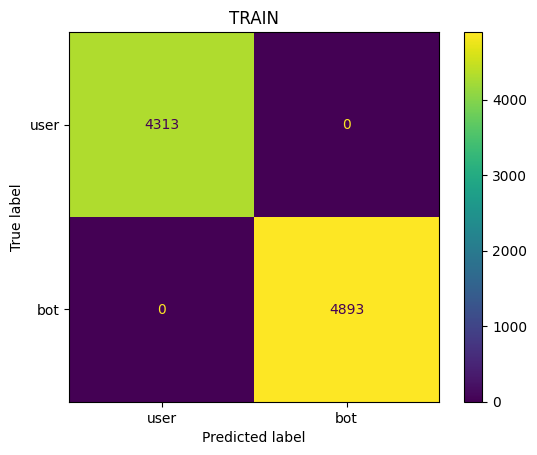

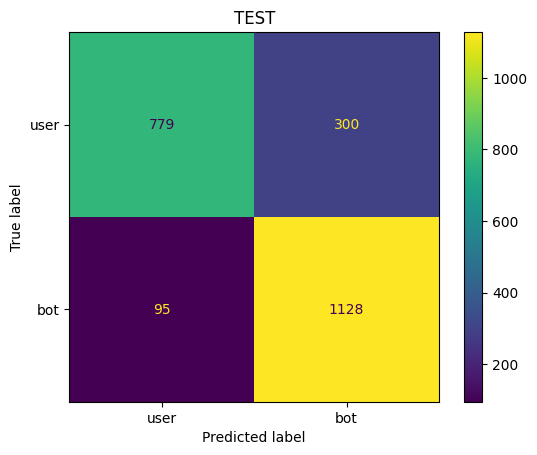

In [45]:
plot_cms(train_pred_rf, test_pred_rf)

### SVM

In [46]:
# Define the hyperparameters
params = dict(
    kernel=['rbf', 'sigmoid'],
    C=[1, 2, 5]
)

# Create the model
svm = SVC()
# Execute gridsearch
scores = gridsearch(train_set_scaled, train_label, svm, params)

scores

GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 2, 5], 'kernel': ['rbf', 'sigmoid']})

In [47]:
# Show best params
scores.best_params_

{'C': 5, 'kernel': 'rbf'}

In [48]:
# Create the model with tuned hyperparamaters
svm = SVC(**scores.best_params_)
# Train SVC
svm.fit(train_set_scaled, train_label)

SVC(C=5)

In [49]:
# Collect data
train_pred_svm = svm.predict(train_set_scaled)
test_pred_svm = svm.predict(test_set_scaled)

predictions["SVM"] = (train_pred_svm, test_pred_svm)

#### SVC Report

In [50]:
report_scores(train_pred_svm, test_pred_svm)

TRAIN
              precision    recall  f1-score   support

        user       0.96      0.50      0.66      4313
         bot       0.69      0.98      0.81      4893

    accuracy                           0.76      9206
   macro avg       0.82      0.74      0.74      9206
weighted avg       0.82      0.76      0.74      9206

TEST
              precision    recall  f1-score   support

        user       0.92      0.52      0.66      1079
         bot       0.69      0.96      0.81      1223

    accuracy                           0.75      2302
   macro avg       0.81      0.74      0.74      2302
weighted avg       0.80      0.75      0.74      2302



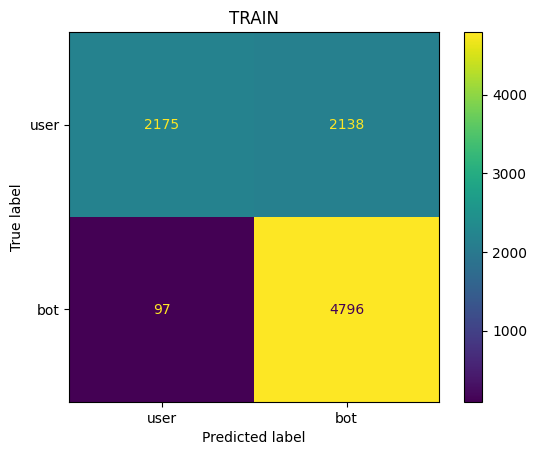

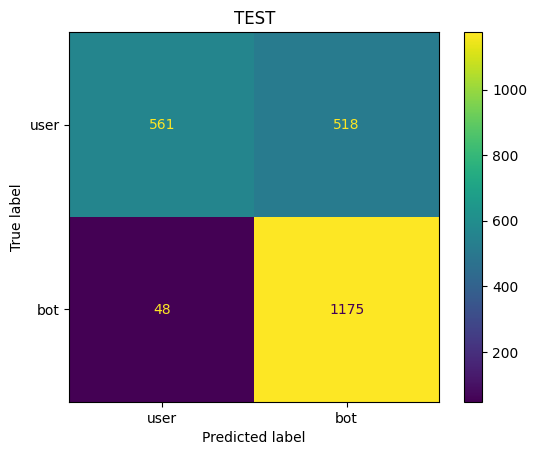

In [51]:
plot_cms(train_pred_svm, test_pred_svm)

### Neural network

In [52]:
x_train_nn = np.reshape(train_set_scaled, (-1, 1, train_set.shape[1]))
x_test_nn = np.reshape(test_set_scaled, (-1, 1, test_set.shape[1]))
y_train_nn = np.asarray(train_label).reshape((-1,1))
y_test_nn = np.asarray(test_label).reshape((-1,1))

In [53]:
def create_nn(hidden_units, hidden_activation):
    #
    # Create the NN with one dense layer
    #
    nn = keras.models.Sequential([
            keras.layers.Flatten(input_shape=(1, train_set.shape[1])),
            keras.layers.Dense(hidden_units, activation=hidden_activation),
            keras.layers.Dense(1, activation='sigmoid')
        ])
    nn.compile(optimizer='adam',
                      loss='mean_squared_error',
                      metrics=['accuracy'])

    return nn

In [54]:
# Define the hyperparameters for NeuralNetwork
params = dict(
    model__hidden_units=[32, 64, 128, 516, 1024, 2048],
    model__hidden_activation=['sigmoid', 'relu', 'tanh']
)

# Create the classifier
nn = KerasClassifier(model=create_nn, epochs = 100, batch_size = 516)
# Execute gridsearch
scores = gridsearch(x_train_nn, y_train_nn, nn, params)

scores

2023-01-02 17:09:29.561272: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-02 17:09:29.561276: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-02 17:09:29.561276: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-02 17:09:29.561272: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-02 17:09:29.561303: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-02 17:09:29.561759: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-02 17:09:29.562653: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-02 17:09:29.580071: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2604 - accuracy: 0.4685
Epoch 2/100
Epoch 2/100
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2542 - accuracy: 0.4959
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2608 - accuracy: 0.5314
Epoch 2/100
Epoch 2/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2448 - accuracy: 0.5637
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2541 - accuracy: 0.5315
Epoch 2/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2479 - accuracy: 0.5098
Epoch 3/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2487 - accuracy: 0.5342
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2465 - accuracy: 0.5316
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2470 - accura

2023-01-02 17:09:34.693651: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
Epoch 1/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2466 - accuracy: 0.5366
Epoch 2/100
 1/14 [=>............................] - ETA: 0s - loss: 0.2451 - accuracy: 0.5484

2023-01-02 17:09:34.990704: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 4ms/step - loss: 0.2435 - accuracy: 0.5747
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 0.2407 - accuracy: 0.6179
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2384 - accuracy: 0.6438
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2363 - accuracy: 0.6531
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2345 - accuracy: 0.6401
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2560 - accuracy: 0.5014
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2330 - accuracy: 0.6480
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2462 - accuracy: 0.5327
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2319 - accuracy: 0.6321
Epoch 9/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2421 - accuracy: 0.6127
Epoch 4/100
14/14 [===

2023-01-02 17:09:35.327682: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 3ms/step - loss: 0.2280 - accuracy: 0.6305
Epoch 15/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2328 - accuracy: 0.6205
Epoch 10/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2284 - accuracy: 0.6395
Epoch 16/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2319 - accuracy: 0.6186
Epoch 11/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2275 - accuracy: 0.6279
Epoch 17/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2313 - accuracy: 0.6192
Epoch 12/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2275 - accuracy: 0.6227
Epoch 18/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2308 - accuracy: 0.6195
Epoch 13/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2273 - accuracy: 0.6260
Epoch 19/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2304 - accuracy: 0.6183
Epoch 14/100


2023-01-02 17:09:35.800967: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 2ms/step - loss: 0.2259 - accuracy: 0.6311
Epoch 35/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2284 - accuracy: 0.6231
Epoch 29/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2290 - accuracy: 0.6258
Epoch 17/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2260 - accuracy: 0.6402
Epoch 36/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2285 - accuracy: 0.6330
Epoch 30/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2288 - accuracy: 0.6219
Epoch 18/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2281 - accuracy: 0.6224
Epoch 31/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2258 - accuracy: 0.6331
Epoch 37/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2285 - accuracy: 0.6232
Epoch 19/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2256 - accuracy: 0.6433
Epoch 38/100


2023-01-02 17:09:36.285410: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 599us/step - loss: 0.2266 - accuracy: 0.6269
Epoch 42/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2343 - accuracy: 0.6316
Epoch 8/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2243 - accuracy: 0.6530
Epoch 59/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2265 - accuracy: 0.6255
Epoch 43/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2264 - accuracy: 0.6369
Epoch 53/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2240 - accuracy: 0.6548
Epoch 60/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2266 - accuracy: 0.6284
Epoch 44/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2267 - accuracy: 0.6472
Epoch 54/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2239 - accuracy: 0.6548
Epoch 61/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2329 - accuracy: 0.6324
Epoch 9/100


2023-01-02 17:09:36.822790: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 2ms/step - loss: 0.2247 - accuracy: 0.6546
Epoch 71/100
Epoch 30/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2287 - accuracy: 0.6270
Epoch 10/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2239 - accuracy: 0.6679
Epoch 79/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2243 - accuracy: 0.6563
Epoch 72/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2282 - accuracy: 0.6243
Epoch 11/100
14/14 [==============================] - 0s 7ms/step - loss: 0.2218 - accuracy: 0.6742
Epoch 83/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2238 - accuracy: 0.6705
Epoch 80/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2243 - accuracy: 0.6404
Epoch 73/100
Epoch 31/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2237 - accuracy: 0.6547
Epoch 12/100
Epoch 81/100
14/14 [==============================] - 0s 1ms/step - loss: 

2023-01-02 17:09:37.306028: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 25/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2258 - accuracy: 0.6317
Epoch 51/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2226 - accuracy: 0.6734
Epoch 91/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2222 - accuracy: 0.6757
Epoch 99/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2265 - accuracy: 0.6338
Epoch 26/100
 1/14 [=>............................] - ETA: 0s - loss: 0.2291 - accuracy: 0.6609Epoch 52/100
Epoch 9/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2224 - accuracy: 0.6768
Epoch 92/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2218 - accuracy: 0.6812
Epoch 100/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2256 - accuracy: 0.6381
Epoch 53/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2224 - accuracy: 0.6711
Epoch 93/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2267 - accuracy:

2023-01-02 17:09:37.714638: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 2ms/step - loss: 0.2238 - accuracy: 0.6673
Epoch 22/100
Epoch 69/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2290 - accuracy: 0.6322
Epoch 70/100
Epoch 11/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2248 - accuracy: 0.6441
Epoch 38/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2296 - accuracy: 0.6396
Epoch 23/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2240 - accuracy: 0.6543
Epoch 71/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2285 - accuracy: 0.6262
Epoch 12/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2236 - accuracy: 0.6633
Epoch 72/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2282 - accuracy: 0.6457
Epoch 39/100
Epoch 24/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2236 - accuracy: 0.6647
Epoch 13/100
Epoch 73/100
14/14 [==============================] - 0s 3ms/

2023-01-02 17:10:26.097234: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


18/18 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.6224
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2274 - accuracy: 0.6310
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2253 - accuracy: 0.6314
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2235 - accuracy: 0.6327
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2212 - accuracy: 0.6362
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2185 - accuracy: 0.6488
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2159 - accuracy: 0.6535
Epoch 8/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2130 - accuracy: 0.6651
Epoch 9/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2098 - accuracy: 0.6666
Epoch 10/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2071 - accuracy: 0.6761
Epoch 11/100
18/18 [=

GridSearchCV(cv=4,
             estimator=KerasClassifier(batch_size=516, epochs=100, model=<function create_nn at 0x29134fa30>),
             n_jobs=-1,
             param_grid={'model__hidden_activation': ['sigmoid', 'relu',
                                                      'tanh'],
                         'model__hidden_units': [32, 64, 128, 516, 1024, 2048]})

In [55]:
# Show best params
scores.best_params_

{'model__hidden_activation': 'relu', 'model__hidden_units': 1024}

In [56]:
best_params = {k.replace('model__', ''): v for k, v in scores.best_params_.items()}
# Create the NN Model with tuned parameters
nn = create_nn(**best_params)
# Train NN
nn.fit(x_train_nn, y_train_nn, epochs = 100, batch_size = 516)

Epoch 1/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2360 - accuracy: 0.6197
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2280 - accuracy: 0.6289
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2260 - accuracy: 0.6288
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2244 - accuracy: 0.6302
Epoch 5/100
18/18 [==============================] - 0s 1ms/step - loss: 0.2228 - accuracy: 0.6339
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2203 - accuracy: 0.6387
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2180 - accuracy: 0.6440
Epoch 8/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2152 - accuracy: 0.6529
Epoch 9/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2122 - accuracy: 0.6665
Epoch 10/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2089 - accuracy: 0.6647
Epoch 11/

In [57]:
# Collect data
train_pred_nn = (nn.predict(x_train_nn) > 0.5).astype("int32")
test_pred_nn = (nn.predict(x_test_nn) > 0.5).astype("int32")

predictions["Neural network"] = (train_pred_nn, test_pred_nn)

72/72 [==============================] - 0s 282us/step


#### NN report

In [58]:
report_scores(train_pred_nn, test_pred_nn)

TRAIN
              precision    recall  f1-score   support

        user       0.95      0.56      0.70      4313
         bot       0.71      0.97      0.82      4893

    accuracy                           0.78      9206
   macro avg       0.83      0.76      0.76      9206
weighted avg       0.82      0.78      0.77      9206

TEST
              precision    recall  f1-score   support

        user       0.92      0.56      0.69      1079
         bot       0.71      0.96      0.81      1223

    accuracy                           0.77      2302
   macro avg       0.81      0.76      0.75      2302
weighted avg       0.81      0.77      0.76      2302



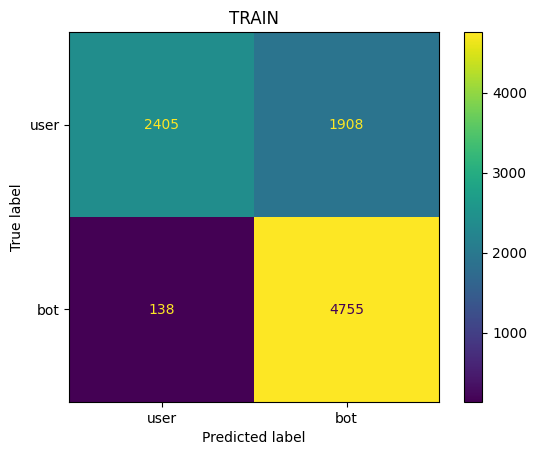

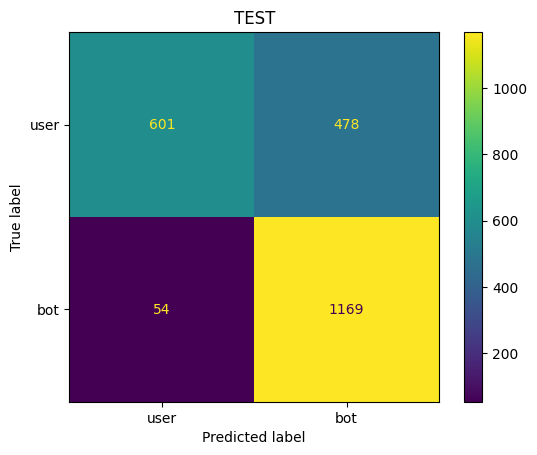

In [59]:
plot_cms(train_pred_nn, test_pred_nn)

## Comparisons

In this section we compare the models, for **Train** and **Test**, using accuracy metric.

In [60]:
def plot_roc(roc_type="test"):
    plt.figure(0).clf()
    is_test = roc_type == "test"
    index = 1 if is_test else 0

    for key, value in predictions.items():
        pred = value[index]
        label = test_label if is_test else train_label
        fpr, tpr, thresh = metrics.roc_curve(label, pred)
        auc = metrics.roc_auc_score(label, pred)
        plt.plot(fpr,tpr,label=f"{key}, auc="+str(round(auc, 2)))
        plt.title("Test" if is_test else "Train")

    plt.legend(loc=0)

### Train

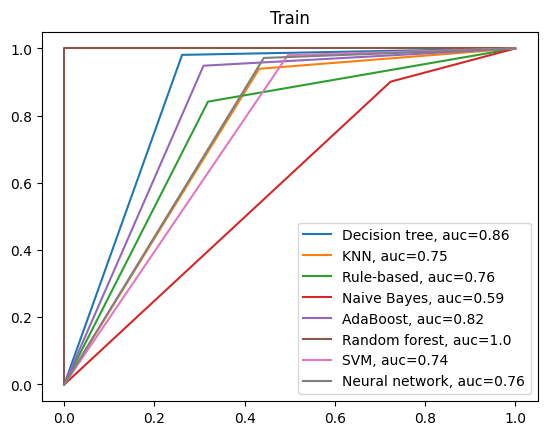

In [61]:
plot_roc("train")

## Test

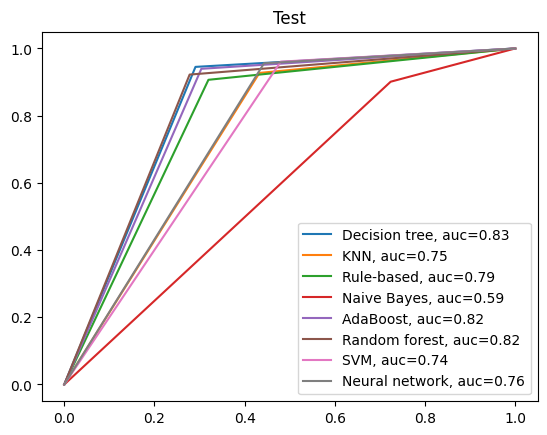

In [62]:
plot_roc("test")